# **PROYECTO IA**
## MODELO MULTIAGENTE PARA LA CREACIÓN DE PROYECTOS DE SOFTWARE



### Dependencias

In [ ]:
!pip install --upgrade -qU langchain openai langgraph langchain-openai langchain_community
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 21.0 MB/s eta 0:00:00


# Algunos imports

In [ ]:
from typing_extensions import TypedDict
from openai import OpenAI

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai.chat_models import ChatOpenAI
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

from IPython.display import Image, display

import json
import uuid
import os
import requests
import base64
import re

# Alguna funciones útiles

In [ ]:
def crear_archivo(contenido: str, extension: str, nombre: str):
    """
    Crea un archivo en el directorio especificado con el contenido y extensión indicados.

    :param contenido: El contenido que se guardará en el archivo.
    :param extension: La extensión del archivo (sin el punto, por ejemplo, 'txt', 'csv').
    :param directorio: El directorio donde se guardará el archivo.
    :param nombre: El nombre del archivo (sin extensión).
    :return: La ruta completa del archivo creado.
    """

    # Construir la ruta completa del archivo
    archivo_ruta = "/content/" + nombre + extension

    # Crear el archivo y escribir el contenido
    with open(archivo_ruta, "w", encoding="utf-8") as archivo:
        archivo.write(contenido)

    return archivo_ruta

In [ ]:
def save_diagram(graph: str, name:str):
    """
    Muestra un diagrama Mermaid a partir del código y lo guarda como archivo PNG en la ruta especificada.

    :param graph: Código del diagrama Mermaid.
    :param save_path: Ruta completa (incluyendo el nombre del archivo) donde se guardará la imagen PNG.
    """
    # Codificar el gráfico en base64
    graph_bytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graph_bytes)
    base64_string = base64_bytes.decode("ascii")

    # Generar la URL de la imagen
    img_url = "https://mermaid.ink/img/" + base64_string

      # Construir la ruta completa del archivo
    archivo_ruta = os.path.join("/content/", name)

    # Descargar y guardar la imagen
    response = requests.get(img_url)
    if response.status_code == 200:
        with open(archivo_ruta, "wb") as file:
            file.write(response.content)
        print(f"Diagrama guardado en: /content/")
    else:
        print(f"Error al descargar la imagen: {response.status_code}")

In [ ]:
def parse_response_and_create_files(response_text, base_path="/content/codigo"):
    # Patrón para identificar archivos y su contenido
    file_pattern = r"# Archivo: (.*?)\n(.*?)(?=(# Archivo:|$))"

    # Buscar todos los archivos y sus contenidos
    matches = re.findall(file_pattern, response_text, re.DOTALL)

    if not matches:
        print("No se encontraron archivos en la respuesta proporcionada.")
        return

    # Procesar cada archivo encontrado
    for match in matches:
        file_path = match[0].strip()  # Ruta del archivo
        file_content = match[1].strip()  # Contenido del archivo

        # Crear la ruta completa
        full_path = os.path.join(base_path, file_path)

        # Crear los directorios necesarios
        os.makedirs(os.path.dirname(full_path), exist_ok=True)

        # Crear el archivo y escribir el contenido
        with open(full_path, "w", encoding="utf-8") as file:
            file.write(file_content)
            print(f"Archivo creado: {full_path}")

# Configuración de retrieves
Este retriever es creado para para procesar texto dividiéndolo en fragmentos,almacenándolo en un vector store y creando un retriever para búsqueda.

In [ ]:
class TextToRetriever:
    def __init__(self, chunk_size=1000, chunk_overlap=200, api_key=None):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.api_key = api_key
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap
        )
        self.vectorstore = None
        self.retriever = None

    def process_text(self, text):
        """
        Divide el texto en fragmentos, crea un vector store y configura el retriever.

        :param text: Texto a procesar.
        :return: Instancia del retriever configurado.
        """
        try:
            # Dividir el texto en documentos
            documents = self.text_splitter.create_documents([text])

            # Crear embeddings y vector store
            embeddings = OpenAIEmbeddings(api_key=self.api_key)
            self.vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings)

            # Configurar el retriever
            self.retriever = self.vectorstore.as_retriever()
            return self.retriever
        except Exception as e:
            raise RuntimeError(f"Error al procesar el texto: {e}")

    def get_retriever(self):
        """
        Obtiene el retriever configurado.

        :return: Instancia del retriever.
        """
        if not self.retriever:
            raise ValueError("El retriever no ha sido configurado. Procesa el texto primero.")
        return self.retriever


# Clase AgentState
Permitirá manejar el estado global del grafo

In [ ]:
# Definir el estado inicial del grafo
class AgentState(TypedDict):
    input_data: str
    bussiness_domain: str
    operation_name: str
    design_solution: str
    sequence_diagram: str
    swagger_spec: str
    code_base: str
    suggestions: str
    feedback_design: str
    documentation: str
    total_iterations: int

# AGENTE 1 - Diseño de la solución
Encargado de generar un diseño de solución a partir de una descripción de problema proporcionada por el usuario.

In [ ]:
class DesignSolutionAgent:

    def __init__(self, client, model="gpt-4o-mini", temperature=0.2, max_tokens=1000):
        self.client = client
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens

    def generate_design_solution(self, state: AgentState):
        """
        Genera un diseño de solución a partir de una descripción del problema.

        :param input_data: Descripción del problema proporcionada por el usuario.
        :return: Diccionario con la solución generada.
        """
        prompt = f"""
        Eres un ingeniero de software. Tu tarea es analizar el contexto del problema descrito por el usuario y proponer un diseño de solución.

        La descripción del problema incluirá:
        - El problema a resolver
        - El flujo de negocio que se seguirá
        - Las plataformas/tecnologías que se usarán en la solución
        - Ejemplos de funcionamiento

        Tu respuesta debe estar estructurada en el siguiente formato, usando lenguaje natural claro y ordenado:
        Dominio de negocio: **Dominio de negocio**
        Nombre de las solución: **Nombre de la solución**:
        <Proporciona un nombre claro y descriptivo para la solución.>

        **Requerimientos funcionales**:
        1. <Requerimiento funcional 1>
        2. <Requerimiento funcional 2>
        3. ...

        **Casos de uso**:
        1. **Nombre del caso de uso**: <Título breve>
          - **Descripción**: <Explica brevemente qué ocurre en este caso de uso.>
          - **Actor**: <Quién interactúa en este caso.>
          - **Precondición**: <Condiciones necesarias antes de que comience este caso de uso.>
          - **Postcondición**: <Resultado esperado después de que finalice este caso.>

        2. **Nombre del caso de uso**: <Título breve>
          - **Descripción**: ...

        **Tecnologías y dependencias**:
        - <Tecnología 1>
        - <Tecnología 2>

        Mantén la respuesta bien organizada, limpia y sin incluir texto adicional.

        Descripción del problema proporcionada por el usuario:
        {state['input_data']}
        """

        print("---------------------------------Generando diseño de solución...")
        # Llamada a OpenAI
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "Eres un ingeniero de software."},
                {"role": "user", "content": prompt}
            ],
            temperature=self.temperature,
            max_tokens=self.max_tokens
        )

        state['design_solution'] = response.choices[0].message.content
        print("---------------------------------Diseño de solución generado:")
        crear_archivo(state['design_solution'], ".txt", "DisenoSolucion")

        return state

# AGENTE 2 - Agente creador de Diagramas
Encargado de generar diagramas de secuencia en formato Mermaid a partir del diseño de una solución.

In [ ]:
class SequenceDiagramAgent:
    def __init__(self, client, model="gpt-4o-mini", temperature=0.2, max_tokens=300):
        self.client = client
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens

    def generate_sequence_diagram(self, state: AgentState):
        """
        Genera un diagrama de secuencia en formato Mermaid a partir del diseño de la solución.

        :param state
        :return: Diccionario con el diagrama de secuencia generado o un mensaje de error.
        """
        prompt = f"""
        Eres un asistente especializado en generar diagramas de secuencia en el formato utilizado por la herramienta Mermaid. Tu tarea es crear un diagrama de secuencia a partir de los requerimientos funcionales y casos de uso proporcionados en el diseño de la solución.

        A continuación, se te proporciona la descripción del diseño de la solución, que incluye los requerimientos funcionales y los casos de uso. Utiliza esta información para definir las interacciones entre actores y componentes del sistema.

        **Reglas**:
        1. Crea un diagrama de secuencia en el lenguaje de Mermaid.
        2. Usa únicamente el formato Mermaid. No agregues ninguna explicación adicional, texto introductorio o comentario fuera del diagrama.
        3. No incluyas encabezados como ```mermaid ni texto adicional que encapsule el diagrama, tampoco comillas como ```.
        4. Cada **caso de uso** debe representarse con sus actores y los mensajes intercambiados entre ellos y el sistema.
        5. Si hay múltiples casos de uso, usa el mismo diagrama.

        **Entrada (Diseño de la solución)**:
        {state['design_solution']}
        """

        print("-------------------GENERANDO DIAGRAMA DE SECUENCIA----------------------")
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "Eres un ingeniero de software. Conoces la herramienta Mermaid y generas el código para un diagrama de secuencia"},
                {"role": "user", "content": prompt}
            ],
            temperature=self.temperature,
            max_tokens=self.max_tokens
        )

        # Procesar respuesta
        state['sequence_diagram'] = response.choices[0].message.content
        print("-------------------DIAGRAMA DE SECUENCIA GENERADO----------------------")
        save_diagram(state['sequence_diagram'], "diagrama_secuencia.png")
        return state

# Agente 3 - Corrección del diseño
Encargado de aplicar las sugerencias que el usuario dé a las salidas de los agentes de diseño

In [ ]:
class DesignCorrectionAgent:
    def __init__(self, client, model="gpt-4o-mini", temperature=0.2, max_tokens=1000):
        self.client = client
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens

    def apply_feedback_design(self, state: AgentState):
        """
        Aplica el feedback al diseño y diagrama de secuencia.
        """
        prompt = f"""
        Eres un asistente experto en ingeniería de software.
        Tu tarea es modificar un diseño técnico basándote en el feedback del usuario.
        Si el feedback es vacío o no tiene que ver con el diseño, debes ignorarlo y dejar el diseño original.

        ### **Diseño Original:**
        {state['design_solution']}

        ### **Diagrama de Secuencia Original:**
        {state['sequence_diagram']}

        ### **Feedback del Usuario:**
        {state['feedback_design']}

        ### **Instrucciones:**
        1. **Analiza** el `feedback_design` e identifica las correcciones necesarias.
        2. **Modifica** el `design_solution` aplicando los cambios.
        3. **Ajusta** el `sequence_diagram` para reflejar las correcciones.
        4. **Responde en JSON** con el siguiente formato:
        "

        {{
            "updated_design_solution": "Nuevo diseño corregido...",
            "updated_sequence_diagram": "Nuevo diagrama corregido..."
        }}

        No agregues etiquetas de inicio o fin de código en la respuesta. Ni caracteres especiales como comillas dobles o triples.
        """

        print("-------------------APLICANDO CORRECCIONES----------------------")
        model_response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": prompt}
            ],
            temperature=self.temperature,
            max_tokens=self.max_tokens
        )

        try:
            response_data = json.loads(model_response.choices[0].message.content)

            state["design_solution"] = response_data["updated_design_solution"]
            state["sequence_diagram"] = response_data["updated_sequence_diagram"]
            save_diagram(state['sequence_diagram'], "diagrama_secuencia.png")
            crear_archivo(state['design_solution'], ".txt", "DisenoSolucion")
            print("-------------------ARCHIVOS CORREGIDOS----------------------")
            return state
        except Exception as e:
            print(f"Error procesando la respuesta del modelo: {e}")
            return state

In [ ]:
def human_feedback_sequence(state: AgentState):
    feedback = interrupt(
        {
            "message": "Por favor revisa el diseño propuesto y los diagramas generador. Type 'ACCEPTED' or provide feedback."
        }
    )
    state['feedback_design'] = feedback
    return state

# Valida si el usuario aceptó el diseño o agregó correcciones
def check_feedback(state: AgentState):
    print("Check feedback: " + str(state['feedback_design']))
    feedback_design_content = state['feedback_design']['suggestions']
    print(feedback_design_content)
    if not feedback_design_content:
        return "retry"
    if feedback_design_content == "ACCEPTED":
        return "continue"
    else:
        return "retry"

# Agente - Agente de creación de especificación OpenApi
Genera especificaciones OpenAPI 3.0 a partir de un plantilla con el diseño y un diagrama de secuencia en formato Mermaid.

In [ ]:
class SwaggerSpecAgent:
    def __init__(self, client, model="gpt-4o-mini", temperature=0, max_tokens=1000):
        self.client = client
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens

    def generate_swagger_spec(self, state: AgentState):
        """
        Genera una especificación OpenAPI 3.0 en formato YAML a partir de una plantilla de diseño y de un diagrama de secuencia.

        :param state
        :return: Diccionario con la especificación OpenAPI 3.0 generada o un mensaje de error.
        """
        prompt = f"""
        Eres un asistente especializado en generación de APIs en formato OpenAPI 3.0 y en el modelo ApiFirst.
        Tu tarea es analizar una plantilla con el diseño de una solución y un diagrama de secuencia en formato Mermaid y, a partir de él, generar una especificación OpenAPI 3.0.

        **Instrucciones**:
        1. Analiza detenidamente el diagrama y la plantilla.
        2. Identifica los actores (clientes o sistemas externos) y las interacciones (endpoints) descritas en el flujo.
        3. Genera una especificación OpenAPI 3.0 en formato YAML que incluya:
            - Información general de la API.
            - Las rutas (endpoints) necesarias.
            - Métodos HTTP adecuados (GET, POST, etc.).
            - Parámetros requeridos (query, path o body).
            - Ejemplos de `request` y `response`.
            - Códigos de estado HTTP más relevantes (como 200, 400 y 500).

        4. **Reglas**:
            - La salida debe ser una especificación OpenAPI 3.0 en formato YAML puro.
            - No agregues texto introductorio, comentarios adicionales o explicaciones fuera del YAML.
            - Asegúrate de mantener el formato correcto para OpenAPI 3.0.

        **Entrada (Diagrama de secuencia en Mermaid)**:
        {state['sequence_diagram']}

        **Entrada (Plantilla de diseño)**:
        {state['design_solution']}

        Genera únicamente la especificación OpenAPI 3.0 en formato YAML.
        No incluyas caracteres de entrada ni salida, como ``` o comillas.
        """

        print("-------------------GENERANDO ESPECIFICACIÓN OPENAPI 3.0----------------------")
        # Llamada a OpenAI
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {"role": "system", "content": ""},
                {"role": "user", "content": prompt}
            ],
            temperature=self.temperature,
            max_tokens=self.max_tokens
        )

        # Procesar respuesta
        state['swagger_spec'] = response.choices[0].message.content.strip()
        print("-------------------ESPECIFICACIÓN OPENAPI 3.0 GENERADA----------------------")
        crear_archivo(state['swagger_spec'], ".yaml", "SwaggerSpec")
        return state

# AGENTES DE CREACIÓN DE CÓDIGO

In [ ]:
class CodeGeneratorAgent:
    def __init__(self, client, model="gpt-4o-mini", temperature=0, max_tokens=1000):
        """
        Inicializa el generador de código con el cliente enviado.

        :param
        """
        self.client = client
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens

    def generate_code(self, state: AgentState):
        """
        Genera el código base del proyecto según la especificación OpenAPI proporcionada.

        :param swagger_spec: Especificación OpenAPI 3.0 en formato YAML.
        :return: Diccionario con el estado que incluye el código base generado.
        """
        prompt = f"""
        Eres un asistente experto en desarrollo de software y generación de código.
        Tu tarea es analizar una especificación y plantilla de diseño con casos de uso, descripción del problema y tecnologías y una especificación swagger OpenAPI 3.0 proporcionada y,
        a partir de esas entradas generar la estructura básica del proyecto según la tecnología indicada por el usuario.

        **Requisitos de la salida**:
        1. Genera la estructura básica del proyecto.
        2. Las clases deben estar correctamente estructuradas, siguiendo los principios **SOLID** y **DRY**.
        3. La salida debe incluir únicamente el código fuente con el lenguaje indicado y comentado para facilitar su comprensión.
        4. El formato de la respuesta debe ser de la siguiente manera:
            # Archivo: directorio/nombrearchivo
            package package.name;
            // Clase de ejemplo
          Ten en cuenta el nombre del archivo lleve el directorio al que pertenece.
        5. Ten en cuenta que archivos generales de configuración y dependencias a agregar al proyecto.

        **Tecnología solicitada**: Java Spring Boot - Gradle 7.0

        **Reglas**:
        - No agregues explicaciones ni comentarios fuera del código.
        - Genera únicamente el código fuente y la estructura básica del proyecto.

        Especificación swagger: {state['swagger_spec']}

        Plantilla de diseño: {state['design_solution']}
        """
        print("-------------------GENERANDO CÓDIGO----------------------")

        messages = [
            {"role": "system", "content": "Eres un desarrollador experto en Java y el framework Spring"},
            {"role": "user", "content": prompt}
        ]

        response = self.client.chat.completions.create(
            model='gpt-4o-mini',
            messages=messages,
            max_tokens=2000
        )
        code_base = response.choices[0].message.content
        print("-------------------CÓDIGO GENERADO----------------------")

        state['code_base'] = code_base
        return state


# AGENTE DE VALIDACIÓN DE CÓDIGO
Realiza una revisión de código basado en lineamientos específicos de desarrollo. Si encuentra errores da unas sugerencias

In [ ]:
class CodeReviewAgent:
    def __init__(self, api_key, model="gpt-4.1-2025-04-14", max_tokens=1000):
        self.api_key = api_key
        self.model = model
        self.max_tokens = max_tokens
        self.llm = ChatOpenAI(api_key=api_key, model=model, max_tokens=max_tokens)
        self.initialize_retriever()

    def create_prompt(self):
        """
        Crea el prompt del sistema para la revisión de código.

        :param context: Estándares específicos para la validación del código.
        :return: Instancia de ChatPromptTemplate configurada.
        """
        system_prompt = (
            "Eres un asistente especializado en los lineamientos de desarrollo de una compañía. Tu función será realizar la revisión de código."
            "Te especializas en la estructura de los proyectos y su documentación. Te basas únicamente en los estándares que te serán entregados."
            "Validarás detalladamente unos archivos que serán un texto con este formato: "
            """ # Archivo: directorio/nombre_archivo
                package nombrepaquete;
                // Clase de ejemplo
            """
            "Es decir el nombre del archivo (definiendo el directorio al que pertenece) y su contenido."
            "Revisarás detalladamente cada uno de los archivos. Debes ser bastante estricto en cuanto a nombramientos, estructura y contenido de los archivos."
            "Si encuentras errores, los listarás y dirás su corrección, de esta manera: 'Error: - Correcciones:' No agregues más comentarios."
            "\n"
            "Lineamientos de desarrollo: {context}"
        )
        return ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "{input}"),
            ]
        )

    def review_code(self, state: AgentState):
        """
        Procesa la revisión de código de acuerdo al estado actual.

        :param state: Diccionario con el estado actual que incluye la base de código.
        :return: Estado actualizado con sugerencias y conteo de iteraciones.
        """
        print("-------------------VALIDANDO CODIGO-----------------")

        # Crear el prompt basado en los estándares
        prompt = self.create_prompt()

        # Crear cadenas necesarias para el proceso
        question_answer_chain = create_stuff_documents_chain(self.llm, prompt)
        rag_chain = create_retrieval_chain(self.retriever, question_answer_chain)

        # Incrementar iteraciones y generar sugerencias
        state['total_iterations'] = state.get('total_iterations', 0) + 1
        state['suggestions'] = rag_chain.invoke({"input": state['code_base']})['answer']

        print("-------------------SUGERENCIAS----------------------")
        print(state['suggestions'])
        return state


    def initialize_retriever(self):
        lineamientos = "/content/EstructuraMSComunes.txt"
        with open(lineamientos, "r") as f:
            documentation_content = f.read()
        textToRetriever = TextToRetriever(api_key=self.api_key)
        textToRetriever.process_text(documentation_content)
        self.retriever = textToRetriever.get_retriever()



# AGENTE DE REFACTORING DE CÓDIGO(APLICACIÓN DE LINEAMIENTOS)
Refactoriza el código aplicando las sugerencias generadas por el agente anterior

In [ ]:
class CodeRefactorAgent:
    def __init__(self, client, model='gpt-4o-mini'):
        self.client = client
        self.model = model

    def refactor_code(self, state: AgentState):
        """
        Realiza la refactorización de código basada en las sugerencias proporcionadas.

        :param state: Diccionario que contiene las sugerencias y la base de código.
        :return: Diccionario actualizado con la base de código refactorizada.
        """
        prompt = f"""
          Eres un asistente experto en desarrollo de software y refactoring de código.

          **Entrada**:
          - Recibirás un texto que contiene archivos con las clases de un proyecto en este formato:
              # Archivo: directorio/nombre_archivo
              package nombrepaquete;
              // Clase de ejemplo
              ...
            Ten en cuenta que el nombre del archivo lleva el directorio al que pertenece.

          **Tecnología solicitada**: Java Spring Boot

          **Reglas**:
          - Tendrás en cuenta las siguientes sugerencias: {state['suggestions']}
          - No agregues explicaciones ni comentarios fuera del código.
          - Genera únicamente el código fuente y la estructura básica del proyecto.
          - El formato de la respuesta debe ser de la siguiente manera:
            # Archivo: directorio/nombrearchivo
            package package.name;
            // Clase de ejemplo
            Ten en cuenta el nombre del archivo lleve el directorio al que pertenece.

          Código:
          {state['code_base']}
        """
        messages = [
            {"role": "system", "content": "Eres un desarrollador experto en Java y el framework Spring"},
            {"role": "user", "content": prompt}
        ]

        try:
            print("-------------------REFACTORIZANDO CÓDIGO----------------------")
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                max_tokens=2000
            )

            # Procesar respuesta
            state['code_base'] = response.choices[0].message.content
            parse_response_and_create_files(state['code_base'])
            print("-------------------CÓDIGO REFACTORIZADO----------------------")
            return state

        except Exception as e:
            raise RuntimeError(f"Error durante la refactorización del código: {e}")

# Sección nueva

# Grafo


In [ ]:
api_key = 'your_api_key'

# cliente OpenAI
client = OpenAI(api_key= api_key)

# id para la ejecucion
thread_id = str(uuid.uuid4())

# Inicializando checkpointer
checkpointer = MemorySaver()

# Inicialización de agentes
a_design_solution = DesignSolutionAgent(client=client)
a_sequence_diagram = SequenceDiagramAgent(client=client)
a_design_correction = DesignCorrectionAgent(client=client)
a_swagger_spec = SwaggerSpecAgent(client=client)
a_code_generator = CodeGeneratorAgent(client=client)
a_code_review = CodeReviewAgent(api_key=api_key)
a_code_refactor = CodeRefactorAgent(client=client)

graph = StateGraph(AgentState)

graph.add_node("generate_design_solution", a_design_solution.generate_design_solution)
graph.add_node("generate_sequence_diagram", a_sequence_diagram.generate_sequence_diagram)

graph.add_node("human_feedback_sequence", human_feedback_sequence)
graph.add_node("apply_design_correction", a_design_correction.apply_feedback_design)

# API First
graph.add_node("generate_swagger_spec", a_swagger_spec.generate_swagger_spec)

graph.add_node("generate_code", a_code_generator.generate_code)
graph.add_node("review_code", a_code_review.review_code)
graph.add_node("refactor_code", a_code_refactor.refactor_code)

graph.add_edge(START, "generate_design_solution")
graph.add_edge("generate_design_solution", "generate_sequence_diagram")
graph.add_edge("generate_sequence_diagram", "human_feedback_sequence")
graph.add_conditional_edges(
            "human_feedback_sequence",
            check_feedback,
            {
                "continue": "generate_swagger_spec",
                "retry": "apply_design_correction"
            }
        )
graph.add_edge("apply_design_correction", "generate_sequence_diagram")
graph.add_edge("generate_swagger_spec", "generate_code")
graph.add_edge("generate_code", "review_code")
graph.add_edge("review_code", "refactor_code")
graph.add_edge("refactor_code", END)

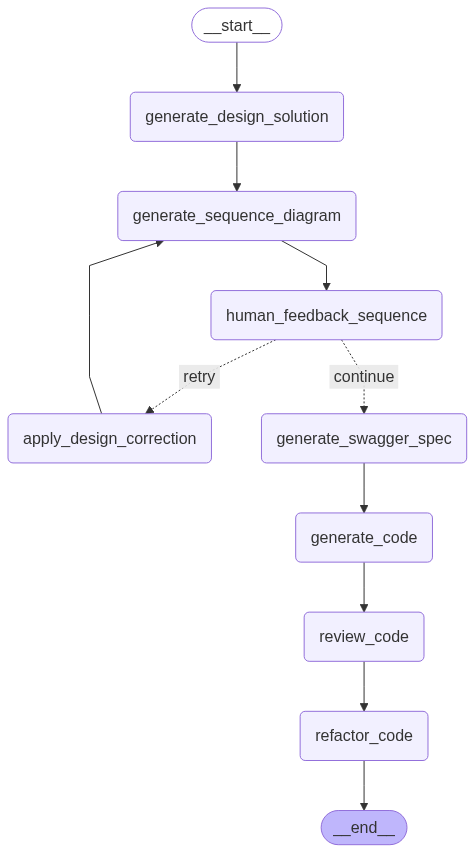

In [ ]:
app = graph.compile(checkpointer=checkpointer)
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
app.invoke({"input_data": """"Requerimos un servicio que permita la consulta de la lista de superheroes almacenados en la bd mysql llamada VOUGHTDB.
  En la consulta se podrán añadir filtros por nombre, año, y país de nacimiento. La respuesta contendrá por cada superheroe su nombre, descripción, la lista de enemigos que ha vencido, lista de poderes y lista de debilidades""",
            "total_iterations": 0},
           config={ "configurable": {"thread_id": thread_id}
            })

---------------------------------Generando diseño de solución...
---------------------------------Diseño de solución generado:
-------------------GENERANDO DIAGRAMA DE SECUENCIA----------------------
-------------------DIAGRAMA DE SECUENCIA GENERADO----------------------
Diagrama guardado en: /content/


{'input_data': '"Requerimos un servicio que permita la consulta de la lista de superheroes almacenados en la bd mysql llamada VOUGHTDB.\n  En la consulta se podrán añadir filtros por nombre, año, y país de nacimiento. La respuesta contendrá por cada superheroe su nombre, descripción, la lista de enemigos que ha vencido, lista de poderes y lista de debilidades',
 'design_solution': 'Dominio de negocio: **Consulta de Superhéroes**\n\nNombre de la solución: **Servicio de Consulta de Superhéroes**:\n\n**Requerimientos funcionales**:\n1. Permitir la consulta de superhéroes almacenados en la base de datos VOUGHTDB.\n2. Implementar filtros por nombre, año y país de nacimiento.\n3. Devolver información detallada de cada superhéroe, incluyendo nombre, descripción, lista de enemigos vencidos, lista de poderes y lista de debilidades.\n\n**Casos de uso**:\n1. **Consulta de Superhéroes**: \n   - **Descripción**: El usuario realiza una consulta para obtener la lista de superhéroes, aplicando filtros

# Retomando la secuencia agregando correcciones:

In [ ]:
app.invoke(
      Command(resume={
          "suggestions": "1. Cambia las tecnologías. En este caso usaremos Java 17 - Spring, Oracle y gradle. 2. El usuario que quiera consumir la api debe enviar la clave secreta de VOUGHT en los headers. 3. Debe ser un único servicio en el que los filtros puedan enviarse en los parámetros de la solicitud"
      }), config={"configurable": {"thread_id": thread_id}}
  )

Check feedback: {'suggestions': '1. Cambia las tecnologías. En este caso usaremos Java 17 - Spring, Oracle y gradle. 2. El usuario que quiera consumir la api debe enviar la clave secreta de VOUGHT en los headers. 3. Debe ser un único servicio en el que los filtros puedan enviarse en los parámetros de la solicitud'}
1. Cambia las tecnologías. En este caso usaremos Java 17 - Spring, Oracle y gradle. 2. El usuario que quiera consumir la api debe enviar la clave secreta de VOUGHT en los headers. 3. Debe ser un único servicio en el que los filtros puedan enviarse en los parámetros de la solicitud
-------------------APLICANDO CORRECCIONES----------------------
Diagrama guardado en: /content/
-------------------ARCHIVOS CORREGIDOS----------------------
-------------------GENERANDO DIAGRAMA DE SECUENCIA----------------------
-------------------DIAGRAMA DE SECUENCIA GENERADO----------------------
Diagrama guardado en: /content/


{'input_data': '"Requerimos un servicio que permita la consulta de la lista de superheroes almacenados en la bd mysql llamada VOUGHTDB.\n  En la consulta se podrán añadir filtros por nombre, año, y país de nacimiento. La respuesta contendrá por cada superheroe su nombre, descripción, la lista de enemigos que ha vencido, lista de poderes y lista de debilidades',
 'design_solution': 'Dominio de negocio: **Consulta de Superhéroes**\n\nNombre de la solución: **Servicio de Consulta de Superhéroes**:\n\n**Requerimientos funcionales**:\n1. Permitir la consulta de superhéroes almacenados en la base de datos VOUGHTDB.\n2. Implementar filtros por nombre, año y país de nacimiento, que se envían como parámetros en la solicitud.\n3. Devolver información detallada de cada superhéroe, incluyendo nombre, descripción, lista de enemigos vencidos, lista de poderes y lista de debilidades.\n4. El usuario debe enviar la clave secreta de VOUGHT en los headers para consumir la API.\n\n**Casos de uso**:\n1. **

# Retomando la secuencia aceptando el diseño:

In [ ]:
app.invoke(
      Command(resume={
          "suggestions": "ACCEPTED"
      }), config={"configurable": {"thread_id": thread_id}}
  )

Check feedback: {'suggestions': 'ACCEPTED'}
ACCEPTED
-------------------GENERANDO ESPECIFICACIÓN OPENAPI 3.0----------------------
-------------------ESPECIFICACIÓN OPENAPI 3.0 GENERADA----------------------
-------------------GENERANDO CÓDIGO----------------------
-------------------CÓDIGO GENERADO----------------------
-------------------VALIDANDO CODIGO-----------------
-------------------SUGERENCIAS----------------------
Error:
- La estructura y nombramiento de paquetes, clases y archivos no sigue los lineamientos exigidos.
- Los nombres de los paquetes y clases no cumplen con las convenciones de infinitivo singular y no están organizados según la funcionalidad (ej: no hay operacion como consultarsuperheroe).
- Uso inconsistente/no permitido de mayúsculas en nombres de paquetes.
- El paquete principal debe iniciar como com.vought.(dominio)-ms según lineamiento.
- Faltan los paquetes commons, config y utils.
- Falta organización por operación (ej: consultarsuperheroe/controller, con

{'input_data': '"Requerimos un servicio que permita la consulta de la lista de superheroes almacenados en la bd mysql llamada VOUGHTDB.\n  En la consulta se podrán añadir filtros por nombre, año, y país de nacimiento. La respuesta contendrá por cada superheroe su nombre, descripción, la lista de enemigos que ha vencido, lista de poderes y lista de debilidades',
 'design_solution': 'Dominio de negocio: **Consulta de Superhéroes**\n\nNombre de la solución: **Servicio de Consulta de Superhéroes**:\n\n**Requerimientos funcionales**:\n1. Permitir la consulta de superhéroes almacenados en la base de datos VOUGHTDB.\n2. Implementar filtros por nombre, año y país de nacimiento, que se envían como parámetros en la solicitud.\n3. Devolver información detallada de cada superhéroe, incluyendo nombre, descripción, lista de enemigos vencidos, lista de poderes y lista de debilidades.\n4. El usuario debe enviar la clave secreta de VOUGHT en los headers para consumir la API.\n\n**Casos de uso**:\n1. **